In [12]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize

In [7]:
url ='https://github.com/dknife/ML/raw/main/data/Proj1/40/'

imgR, imgC, channel = 24,24,3
images = []

for i in range(40):
  file = url+ 'img{0:02d}.jpg'.format(i+1)
  img = imread(file)
  img = resize(img, (imgR,imgC, channel))
  images.append(img)

# img01.jpg부터 img40.jpg까지의 파일있음. 해당 URL에 파일이름을 붙여 사이킷 이미지의 io 서브 모듈에 있는 imread()함수로 넘겨줌=> img 얻음
# 이 이미지들의 크기가 제각각이므로 transfrom에 있는 resize함수를 통해 24,24로 변경, 채널은 3으로 지정

In [8]:
def plot_images(nRow, nCol, img):
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
  for i in range(nRow):
    for j in range(nCol):
      if nRow <=1: axis = ax[j]
      else: axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img[i*nCol+j])

<Figure size 432x288 with 0 Axes>

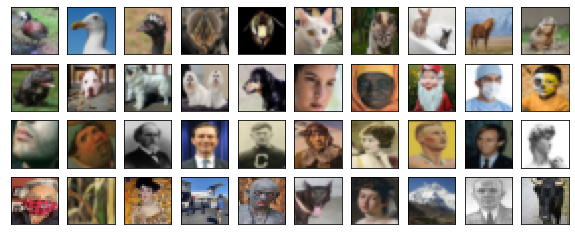

In [10]:
plot_images(4,10,images)

<Figure size 432x288 with 0 Axes>

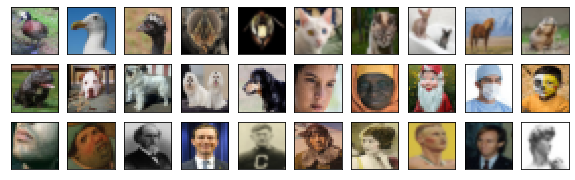

<Figure size 432x288 with 0 Axes>

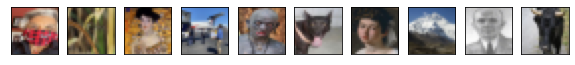

In [13]:
#3. 훈련용 데이터와 검즘용 데이터 분리

X=np.array(images[:30])
X_test = np.array(images[30:])
plot_images(3,10,X)
plot_images(1,10,X_test)

In [16]:
#4. 입력 데이터 준비
# 훈련과 검증 단계를 위해 분리한 데이터는 모두 잡음이 없는 깨끗한 이미지로 정답 레이블로 사용
# 훈련 과정은 잡음이 섞인 입력 데이터를 가지고 이 정답 레이블을 만들어내는것
# 따라서 훈련시 입력으로 사용할 수 있는 잡음이 섞인 이미지를 생성
# 잡음은 넘파이를 통해새성, 잡음의 형식은 이미지 배열과 같은 차원을 만들어서 넘겨야함.
#(데이터 개수, 이미지행, 이미지열, 채널의수)의 차원으로 정규분포를 따를 잡음(randn)을생성

X_noisy = X+np.random.randn(len(X), imgR, imgC, channel)*0.1
X_noisy = np.clip(X_noisy,0,1)
X_test_noisy = X_test+np.random.randn(len(X_test),imgR,imgC,channel)*0.1
X_test_noisy = np.clip(X_test_noisy,0,1)

<Figure size 432x288 with 0 Axes>

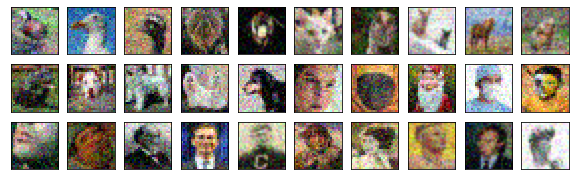

<Figure size 432x288 with 0 Axes>

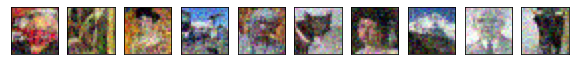

In [15]:
plot_images(3,10,X_noisy)
plot_images(1,10,X_test_noisy)

In [18]:
#5. 분류기 입출력 데이터 형식에 맞추어 훈련하기
# sklearn k-nn 분류기는 이미지와 같은 2차원 이상의 데이터를 다루지 않고, 모든 입력은 1차원 벡터 데이터로 취급
# 따라서 입력 이미지 데이터 배열은 (이미지의수, 이미지 픽셀의 수) 형태로 변형되어야함.
# 이것은 numpy의 resize()함수로 가능.
# 이때 -1을 입력하면 해당 축의 크기는 나머지 축에 지정된 값에 따라 맞추어 자동으로 설정됨
# 따라서 훈련용 데이터의 잡음 이미지와 깨끗한 이미지는 다음과 같이 한 줄로 펼칠수있음.
# 이때 분류기의 출력 레이블로 사용될 깨끗하 ㄴ이미지 X_flat은 X를 변형하여 한줄로 펼친 뒤에 255를 곱합
# 이것은 넘파이로 읽은 이미지의 각 픽셀이 가진 0 에서 1사이의 부동소수점 값을 0에서 255사이의 정수로 만들기 위한 것.
# knn분류기의 출력은 클래스의 레이블이므로, 0~255 사이의 부호없는 정수로 만드는것

X_noisy_flat = X_noisy.reshape(-1, imgR*imgC*channel)
X_flat = np.array(X.reshape(-1, imgR*imgC*channel)*255, dtype=np.uint)

In [20]:
#  잡음 이미지를 입력으로 꺠끗한 이미지를 정답으로 분류기 훈련
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_noisy_flat,X_flat)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

<Figure size 432x288 with 0 Axes>

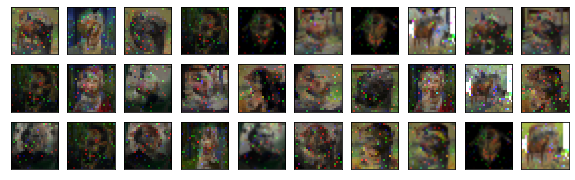

In [21]:
#얼마나 분류가 잘됐는지 잡음이미지를 제공해 예측, 실망스러움 ,30개의 이미지 훈련해서는 픽셀예측이 어려움
denoised_result = knn.predict(X_noisy_flat)
denoised_result = denoised_result.reshape(-1, imgR, imgC, channel)
plot_images(3,10, denoised_result)

In [24]:
#6. 데이터를 증강하여 훈련 효과 높이기
# 데이터부족 => 데이터를 변형하여 수를 늘림 (잡음을 추가해서 잡음 데이터 생성)
# 데이터에 잡음을 추가하는 일을 원하는 만큼 반복하여 결과를 모아둠, 새롭게 만든 데이터에 사용될 정답 레이블은 원래의 정답 레이블을 아무조작없이 쌓아나가면 된다
# 데이터를 증강해서 덧붙이는 횟수를 100으로 n_augmentation지정
# 잡음을  추가하여 얻은 이미지를 X_noisy_aug로,
# X에 있는 깨끗한 이미지를 0에서 255사이의 정수를 데이터를 갖는 출력용으로, 
# 변형한 레이블 데이터를 y_label로 지정
# 증강횟수만큼 반복하여 잡음 이미지 생성 및 덧붙이기와 레이블 덧붙이기를 하면 원래 데이터보다 101배 더 많은 데이터 준비가능
# 출력을 통해 데이터가 30장에서 3030으로 늘어난것 확인가능
# 넘파이의 append()함수 사용, 이 함수는 (A,B,axis)인자를 통해 A와 B를 결합한 배열을 반환
# 이때 axis=0을 지정하면 행을 늘려가며 결합하고, axis=1을 지정하면 열을 늘려가며 병합

n_augmentation = 100
X_noisy_aug= X+ np.random.rand(len(X),imgR,imgC, channel)*0.2
y_label = np.array(X*255, dtype = np.uint)
y= y_label

print(X_noisy.shape)
for i in range(n_augmentation):
  noisy_data = X+np.random.randn(len(X), imgR, imgC, channel)*0.2
  X_noisy_aug = np.append(X_noisy_aug, noisy_data, axis=0)
  y= np.append(y,y_label,axis =0)

X_noisy_aug = np.clip(X_noisy_aug, 0,1)
X_noisy_aug.shape, y.shape

(30, 24, 24, 3)


((3030, 24, 24, 3), (3030, 24, 24, 3))

<Figure size 432x288 with 0 Axes>

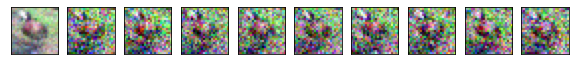

In [26]:
plot_images(1,10,X_noisy_aug[0:300:30]) #슬라이싱을 이용하여 같은 데이터를 사용하여 잡음을 추가한 이미지가 얼마나 다양한지 확인

<Figure size 432x288 with 0 Axes>

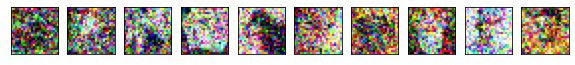

<Figure size 432x288 with 0 Axes>

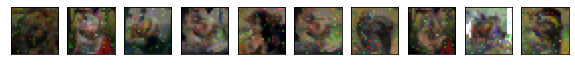

In [29]:
#7. 검증 데이터로 일반화 능력을 살펴보자
# 잡음이 더욱 강하게 발생했을때 잘 찾는지 확인 => 0~20 사이의 난수 정수를 하나 구한 뒤에 깨끗한 이미지가 담겨있는 X배열에서 10개를 가지고옴
# 이미지들에 표준편차 0.4의 강한 잡음으로 data를 만듬
# 그리고 이데이터를 knn분리기에 적합한 차원으로 변형하여 data_flat에 담는다
# 결과로 얻은 배열을 이미지 형태로 다시 변형, 데이터와 예측 결과를 화면에 그려봄 => 잘찾음

rndidx = np.random.randint(0,20)
data = X[rndidx:rndidx+10] + np.random.randn(10, imgR, imgC, channel)*0.4
data = np.clip(data,0,1)
data_flat = data.reshape(-1 ,imgR*imgC*channel)

denoised = knn.predict(data_flat)

denoised = denoised.reshape(-1, imgR, imgC, channel)
denoised = np.clip(denoised,0,255)

plot_images(1,10,data)
plot_images(1,10, denoised)

<Figure size 432x288 with 0 Axes>

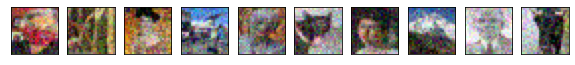

<Figure size 432x288 with 0 Axes>

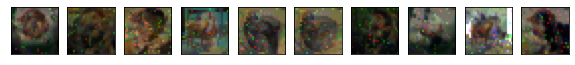

In [30]:
# 검증용으로 준비해 둔 데이터 X_test.
# X_test에 잡음을 넣어 생성해 둔 데이터가 X_test_noisy였는데, 이것을 가지고 예측시도
# 훈련과정에서 본 정답이 30개를 반복해서 만든것이여서 일반화능력 별로임

denoised = knn.predict(X_test_noisy.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR,imgC, channel)

plot_images(1,10,X_test_noisy)
plot_images(1,10,denoised)

In [32]:
#8. 데이터증강으로 일반화 능력을 높여보자
# 일반화 능력을 높이기 위해 입력데이터를 증강해봄
# 이번에는 출력 이미지를 다양한 방법으로 왜곡시켜 정답 레이블을 증강시키고, 입력은 증강된 정답 레이블 정보에 잡음을 넣어서 생성해보기
# 이미지르 다양하게 변형하여 새로운 데이터를 만들어내는 도구로 케라스 API에 ImageDataGenerator 클래스 사용
# 이 클래스는 다음과 같이 생성할 때 이미지의 회전, 확대축소, 기울이기, 상하좌우 반전과 관련된 선택 사항을 지정하여 원래 이미지를 변형하여 결과를 만들어냄

#### 이미지 데이터를 증강시키기 ###
from keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    rotation_range = 360,
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip=True,
    vertical_flip=True
)

In [36]:
# 이 클래스는 반복자를 생성하여 이미지를 계속 생성가능
# 반복자는 ImageDataGenerator의 flow() 메서드에 원본 이미지 데이터를 집어 넣어 생성
# 반복자는 next() 함수를 호출할 때마다 데이터를 반환
# 우선 깨끗한 이미지를 담고있는 X를 이용하여 처음 증강된 레이블 데이터를 담고있을 y_aug생성
# 그리고 이 이미지가 데이터 증강에 사용될 원본 이미지가 된다.
# 이미지가 몇개인지는 nData에 저장해둠

y_aug = X.reshape(-1, imgR,imgC,channel)
it = image_generator.flow(y_aug)
nData = y_aug.shape[0]

In [37]:
# 이를 이용해 데이터 증강.
# 입력데이터는 레이블 데이터 y_aug에 잡음을 섞어 x_aug로 만듬

X_aug = y_aug+ np.random.randn(nData, imgR, imgC, channel)*0.1

In [38]:
#실제 데이터 증강에 들어간다.
#데이터를 증강시킬 횟수를 정해 반복, 이미지 생성기의 반복자가 가진 next()를 호출해 새로운 이미지 만들어냄
#이것이 새로운 레이블 new_y가 되고, 새로운 입력 new_x는 여기에 잡음을 추가
#그리고 두 데이터를 원래의 레이블 y_aug, 입력 데이터 X_aug에 계속 덧붙여감

n_augmentation = 500
for _ in range(n_augmentation):
  new_y = it.next()
  new_X = new_y + np.random.randn(nData, imgR, imgC, channel)*0.1
  y_aug = np.append(y_aug, new_y)
  X_aug = np.append(X_aug, new_X)

y_aug = np.array(y_aug*255, dtype = np.uint)
y_aug = y_aug.reshape(-1, imgR, imgC, channel)
X_aug = X_aug.reshape(-1, imgR, imgC, channel)

<Figure size 432x288 with 0 Axes>

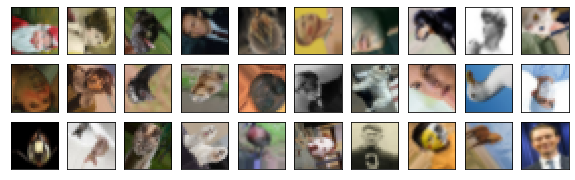

In [41]:
# 출력은 0에서 255, 입력은 0에서 1사이의 이미지를 갖는 이미지인데, 잡음 등의 이유로 범위를 넘지않도록 클리핑
y_aug = np.clip(y_aug, 0, 255)
X_aug = np.clip(X_aug,0,1)
plot_images(3, 10, y_aug[30:])

In [43]:
# 9. 새로 학습하고 검즘용 데이터 적용하기
#증강된 데이터를 이용하여 학습을 새로 수행, 이때 이미지를 1차원으로 펼친다.

X_aug_flat = X_aug.reshape(-1,imgR*imgC*channel)
y_aug_flat = y_aug.reshape(-1, imgR*imgC*channel)
knn.fit(X_aug_flat, y_aug_flat)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

<Figure size 432x288 with 0 Axes>

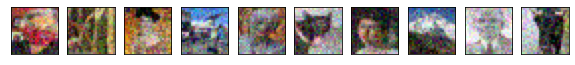

<Figure size 432x288 with 0 Axes>

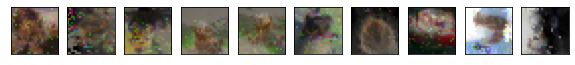

In [44]:
# 검증용 데이터를 모델에 입력하여 예측진행
# 검증데이터와 예측 결과를 화면에 출력하는 일진행
# 완전히 새로운 데이터에 대해서는 답을 잘 찾지못함
denoised = knn.predict(X_test_noisy.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)
plot_images(1,10,X_test_noisy)
plot_images(1,10,denoised)

<Figure size 432x288 with 0 Axes>

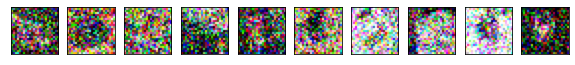

<Figure size 432x288 with 0 Axes>

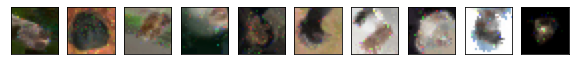

In [45]:
# 강한 잡음을 추가한 이미지에서 잡음을 줄여봄. 이 입력은 훈련에서 사용한 적 없음. 하지만 이때까지 사용한것들과 유사해서 잘찾음
images = it.next()
testX = images+ np.random.randn(nData, imgR, imgC, channel)*0.4
testX = np.clip(testX,0,1)
denoised = knn.predict(testX.reshape(-1, imgR*imgC*channel))
denoised = denoised.reshape(-1, imgR, imgC, channel)

plot_images(1,10,testX)
plot_images(1,10,denoised)